In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import  roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import VotingClassifier

import optuna
from optuna.samplers import TPESampler


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv
/kaggle/input/machine-failure-predictions/machine failure.csv


# Data Processing

In [2]:
def feature_engineering(df):
    df['Power'] = df['TorqueNm'] * df['Rotationalspeedrpm']
    df['TemperatureDifference'] = df['ProcesstemperatureK'] - df['AirtemperatureK']
    df['TemperatureVariability'] = df[['AirtemperatureK', 'ProcesstemperatureK']].std(axis=1)
    df['TemperatureRatio'] = df['ProcesstemperatureK'] / df['AirtemperatureK']
    df['ToolWearRate'] = df['Toolwearmin'] / df['Toolwearmin'].max()
    df['TemperatureChangeRate'] = df['TemperatureDifference'] / df['Toolwearmin']
    df['TemperatureChangeRate'] = np.where(df['TemperatureChangeRate']== float('inf'),1, df['TemperatureChangeRate'])
    df['TotalFailures'] = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)
    
    return df

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv').drop('id', axis = 1)
test = pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv').drop('id', axis = 1)
original = pd.read_csv('/kaggle/input/machine-failure-predictions/machine failure.csv').drop('UDI', axis = 1)
submission = pd.read_csv('/kaggle/input/playground-series-s3e17/sample_submission.csv')

In [4]:
train

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


In [5]:
train.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [6]:
train=train[~((train['Air temperature [K]']>296) & 
                    (train['Air temperature [K]']<297.5) & 
                    (train['Process temperature [K]']<306.8))]

train=train[~((train['Air temperature [K]']<298) & 
                    (train['Process temperature [K]']>310.5))]

train=train[~((train['Air temperature [K]']>300) & 
                    (train['Process temperature [K]']<308))]

train=train[~((train['Air temperature [K]']>302.5) &
                    (train['Process temperature [K]']<309.8))]

train=train[~((train['Torque [Nm]']>30) & 
                    (train['Torque [Nm]']<70) & 
                    (train['Rotational speed [rpm]']>2300))]

train=train[~((train['Torque [Nm]']<10) & 
                    (train['Rotational speed [rpm]']<1750))]

In [7]:
# Filter the original dataframe based on Machine failure equals 1
df_machine_failures_org = original[original['Machine failure'] == 1]

# Print the separate dataframe
df_machine_failures_org

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
69,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
77,L47257,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
160,L47340,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0
161,L47341,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,L56938,L,298.6,309.8,2271,16.2,218,1,1,0,0,0,0
9764,L56944,L,298.5,309.5,1294,66.7,12,1,0,0,1,0,0
9822,L57002,L,298.5,309.4,1360,60.9,187,1,0,0,0,1,0
9830,L57010,L,298.3,309.3,1337,56.1,206,1,0,0,0,1,0


In [8]:
train[train['Machine failure']==0].iloc[:9661]=original[original['Machine failure']==0]
merged_data=pd.concat([train,original[original['Machine failure']==1]],axis=0,ignore_index=True)
merged_data

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136685,L56938,L,298.6,309.8,2271,16.2,218,1,1,0,0,0,0
136686,L56944,L,298.5,309.5,1294,66.7,12,1,0,0,1,0,0
136687,L57002,L,298.5,309.4,1360,60.9,187,1,0,0,0,1,0
136688,L57010,L,298.3,309.3,1337,56.1,206,1,0,0,0,1,0


In [9]:
# toolwear in merged data
Toolwear_df_0 = merged_data[(merged_data['Machine failure'] == 0) & (merged_data['Tool wear [min]'] == 0)]

# Count the number of rows
count = len(Toolwear_df_0)

# Print the count
print("Number of 0 in Tool wear with Machine failure = 0:", count)

Number of 0 in Tool wear with Machine failure = 0: 3749


In [10]:
Toolwear_df_1= merged_data[(merged_data['Machine failure'] == 1) & (merged_data['Tool wear [min]'] == 0)]

# Count the number of rows
count = len(Toolwear_df_1)

# Print the count
print("Number of 0 in Tool wear with Machine failure = 1:", count)

Number of 0 in Tool wear with Machine failure = 1: 43


In [11]:
merged_data.loc[merged_data['Machine failure']==1,'Tool wear [min]']=merged_data.loc[merged_data['Machine failure']==1,'Tool wear [min]'].replace(0,np.nan)
merged_data.loc[merged_data['Machine failure']==0,'Tool wear [min]']=merged_data.loc[merged_data['Machine failure']==0,'Tool wear [min]'].replace(0,np.nan)
from sklearn.impute import KNNImputer
#df_imputed = merged_data.copy()

# Filter the rows where Tool wear is 0
mask_0 =merged_data['Machine failure'] == 0
mask_1=merged_data['Machine failure'] == 1

# Perform KNN imputation on the Tool wear column for the selected rows
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
#T_df.loc[mask_0,'Tool_wear_min'] = imputer.fit_transform(T_df.loc[mask_0,'Tool_wear_min'].values.reshape(-1,1))
merged_data.loc[mask_1,'Tool wear [min]'] = imputer.fit_transform(merged_data.loc[mask_1,'Tool wear [min]'].values.reshape(-1,1))
merged_data.loc[mask_0,'Tool wear [min]'] = imputer.fit_transform(merged_data.loc[mask_0,'Tool wear [min]'].values.reshape(-1,1))
# Print the updated DataFrame
merged_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140.0,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200.0,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25.0,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197.0,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34.0,0,0,0,0,0,0


In [12]:
# Check if there are any remaining 0 values in the Tool wear column
remaining_zeros = (merged_data['Tool wear [min]'] == 0).sum()

# Print the result
if remaining_zeros == 0:
    print("All 0 values in Tool wear have been replaced.")
else:
    print("There are still", remaining_zeros, "0 values remaining in Tool wear.")

All 0 values in Tool wear have been replaced.


In [13]:
df_1=merged_data[merged_data['Machine failure']==1]
df_1

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
130,L52498,L,303.9,312.8,1345,56.5,21.0,1,0,0,0,0,0
164,L51721,L,302.5,310.4,1307,54.8,174.0,1,0,1,0,0,0
228,M17895,M,300.7,309.7,1878,27.9,20.0,1,0,0,0,0,0
236,L55926,L,297.3,308.6,1258,61.8,144.0,1,0,0,0,1,0
247,L51801,L,303.0,311.3,1341,51.0,174.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136685,L56938,L,298.6,309.8,2271,16.2,218.0,1,1,0,0,0,0
136686,L56944,L,298.5,309.5,1294,66.7,12.0,1,0,0,1,0,0
136687,L57002,L,298.5,309.4,1360,60.9,187.0,1,0,0,0,1,0
136688,L57010,L,298.3,309.3,1337,56.1,206.0,1,0,0,0,1,0


In [14]:
features_index=list(df_1.index)
columns=list(df_1.iloc[:,-5:].columns)
# df_1.loc[features_index,columns]=failures_df_1.loc[features_index,columns]
merged_data.loc[features_index,columns]=df_1.loc[features_index,columns]

In [15]:
failures_df_1 = df_1[(df_1['TWF']==0) & (df_1['HDF']==0) & (df_1['PWF']==0) & (df_1['OSF']==0) & (df_1['RNF']==0) ]
for x in failures_df_1.iloc[:,-5:].columns:
    failures_df_1[x].replace(0,np.nan,inplace=True)

In [16]:
failures_df_1

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
130,L52498,L,303.9,312.8,1345,56.5,21.0,1,NaN,NaN,NaN,NaN,NaN
228,M17895,M,300.7,309.7,1878,27.9,20.0,1,NaN,NaN,NaN,NaN,NaN
888,L50551,L,301.4,310.5,1359,51.2,196.0,1,NaN,NaN,NaN,NaN,NaN
1518,L48514,L,299.0,310.4,1536,49.1,15.0,1,NaN,NaN,NaN,NaN,NaN
1806,M19005,M,301.9,310.5,1543,34.6,86.0,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136598,M20396,M,302.3,311.8,1363,54.0,119.0,1,NaN,NaN,NaN,NaN,NaN
136604,L53121,L,300.6,310.7,1438,48.5,78.0,1,NaN,NaN,NaN,NaN,NaN
136617,L53658,L,300.5,309.8,1663,29.1,145.0,1,NaN,NaN,NaN,NaN,NaN
136661,L55686,L,298.4,309.6,1710,27.3,163.0,1,NaN,NaN,NaN,NaN,NaN


In [17]:
features_index=list(failures_df_1.index)
columns=list(failures_df_1.iloc[:,-5:].columns)
df_1.loc[features_index,columns]=failures_df_1.loc[features_index,columns]


In [18]:
# Create a KNNImputer object
imputer = KNNImputer(n_neighbors=10)  # Specify the number of neighbors to consider

# Impute NaN values in the DataFrame
df_imputed = imputer.fit_transform(df_1.iloc[:,2:])

# Convert the imputed array back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df_1.iloc[:,2:].columns)
df_imputed

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,303.9,312.8,1345.0,56.5,21.0,1.0,0.0,0.9,0.1,0.0,0.0
1,302.5,310.4,1307.0,54.8,174.0,1.0,0.0,1.0,0.0,0.0,0.0
2,300.7,309.7,1878.0,27.9,20.0,1.0,0.2,0.3,0.4,0.1,0.0
3,297.3,308.6,1258.0,61.8,144.0,1.0,0.0,0.0,0.0,1.0,0.0
4,303.0,311.3,1341.0,51.0,174.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2464,298.6,309.8,2271.0,16.2,218.0,1.0,1.0,0.0,0.0,0.0,0.0
2465,298.5,309.5,1294.0,66.7,12.0,1.0,0.0,0.0,1.0,0.0,0.0
2466,298.5,309.4,1360.0,60.9,187.0,1.0,0.0,0.0,0.0,1.0,0.0
2467,298.3,309.3,1337.0,56.1,206.0,1.0,0.0,0.0,0.0,1.0,0.0


In [19]:
# Specify the failure columns
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Apply the condition and replace values in the failure columns
df_imputed[failure_columns] = df_imputed[failure_columns].applymap(lambda x: 0 if x < 0.1 else 1)
df_imputed

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,303.9,312.8,1345.0,56.5,21.0,1.0,0,1,1,0,0
1,302.5,310.4,1307.0,54.8,174.0,1.0,0,1,0,0,0
2,300.7,309.7,1878.0,27.9,20.0,1.0,1,1,1,1,0
3,297.3,308.6,1258.0,61.8,144.0,1.0,0,0,0,1,0
4,303.0,311.3,1341.0,51.0,174.0,1.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2464,298.6,309.8,2271.0,16.2,218.0,1.0,1,0,0,0,0
2465,298.5,309.5,1294.0,66.7,12.0,1.0,0,0,1,0,0
2466,298.5,309.4,1360.0,60.9,187.0,1.0,0,0,0,1,0
2467,298.3,309.3,1337.0,56.1,206.0,1.0,0,0,0,1,0


In [20]:
features_index=list(df_imputed.index)
columns=list(df_imputed.iloc[:,-5:].columns)
# df_1.loc[features_index,columns]=failures_df_1.loc[features_index,columns]
merged_data.loc[features_index,columns]=df_imputed.loc[features_index,columns]

<Axes: >

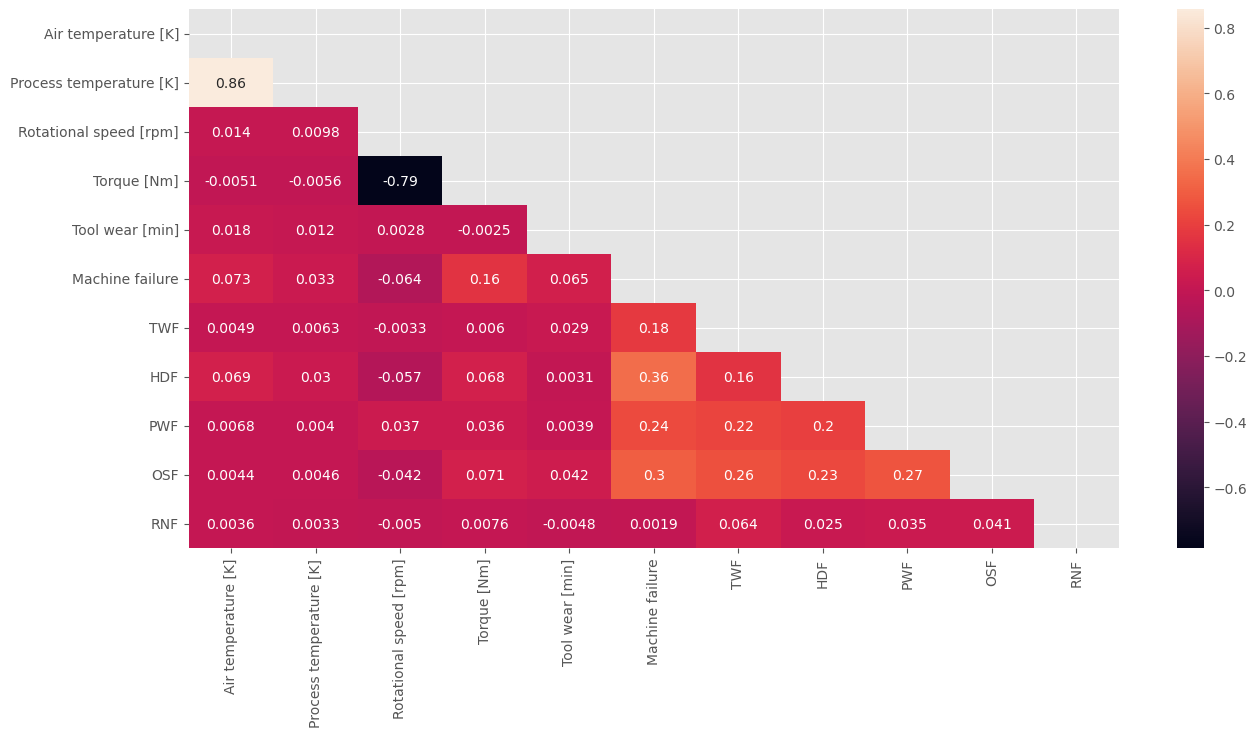

In [21]:
plt.figure(figsize=(15,7))
corr_matrix = merged_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(merged_data.corr(),mask=mask,annot=True)

In [22]:
# train = pd.concat([train, original]).reset_index(drop = True)

In [23]:
merged_data = merged_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
merged_data.columns

Index(['ProductID', 'Type', 'AirtemperatureK', 'ProcesstemperatureK',
       'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Machinefailure',
       'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [25]:
train = feature_engineering(merged_data)
test = feature_engineering(test)

In [26]:
scaler_column = ["AirtemperatureK", "ProcesstemperatureK", "Rotationalspeedrpm", "TorqueNm", "Toolwearmin","TWF", "HDF", "PWF", "OSF", "RNF", "Power", "TemperatureVariability", "TemperatureRatio", "ToolWearRate", "TemperatureChangeRate", "TotalFailures"]

In [27]:
scaler = RobustScaler()

train[scaler_column] = scaler.fit_transform(train[scaler_column])
test[scaler_column] = scaler.transform(test[scaler_column])

# Base Model

In [28]:
lgbm_params = {
    'n_estimators': 1100,
    'num_leaves': 12,
    'max_depth': 8, 
    'min_child_samples': 12,
    'learning_rate': 0.044,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.001,
    'reg_lambda': 0.002,
    'subsample': 0.7,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'max_bin': 1000,
    'n_jobs': -1,
    'bagging_freq': 1, 
    'random_state': 42
}

cb_params = {
    'n_estimators': 2650,
    'depth': 72,
    'learning_rate': 0.0025596625523408217,
    'max_bin': 200,
    'random_strength': 0.23,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bayesian',
    'objective':'Logloss',
    "loss_function": "AUC",
    'eval_metric': "AUC",
    'l2_leaf_reg':  0.015260377498962947,
    'min_child_samples': 70,
    'random_state': 13,
    'silent': True,
    'task_type': 'GPU',
}

xgb_params = {
     'reg_alpha': 0.18727857702097278,
     'reg_lambda': 0.77217672456579,
     'learning_rate': 0.043011675696849064,
     'max_depth': 15,
     'subsample': 0.8370545840097189,
     'n_estimators' : 1500,
     'gamma':0,
     'tree_method':'gpu_hist',
     'predictor':'gpu_predictor',
}

models = [
    ('xgb', XGBClassifier(**xgb_params)),
    ('lgb', LGBMClassifier(**lgbm_params)),
    ('cb', CatBoostClassifier(**cb_params))
]

In [29]:
feature_names = train.drop('Machinefailure', axis = 1).columns.tolist()

In [30]:
X = train.drop(columns = ['Machinefailure'], axis = 1)
y = train['Machinefailure']

In [31]:
kf = KFold(n_splits=10, shuffle=True, random_state = 13)
train_roc, valid_roc = [], []

# Optuna Model

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
def objective(trial):
    X = train.drop(columns = ['Machinefailure'], axis = 1)
    y = train['Machinefailure']
    
    kf = KFold(n_splits=10, shuffle=True, random_state = 13)
    
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 5000),
        'max_depth': trial.suggest_int('max_depth', 3, 250),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'max_bin': trial.suggest_int('max_bin', 50, 400),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'bootstrap_type': 'Poisson',
        'grow_policy': 'Lossguide',
        'random_seed': 13,
        'task_type': 'GPU',
        'objective':'Logloss',
        'eval_metric': 'AUC',
        'silent': True
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
        print(f"Fold {i}:")
        X_train = X.loc[train_index].to_numpy()
        y_train = y.loc[train_index].to_numpy()

        X_valid = X.loc[valid_index].to_numpy()
        y_valid = y.loc[valid_index].to_numpy()
    
        pool_train = Pool(X_train, y_train, feature_names = feature_names, cat_features = ['ProductID', 'Type'])
        pool_valid = Pool(X_valid, y_valid, feature_names = feature_names, cat_features = ['ProductID', 'Type'])

        cb = CatBoostClassifier(**cb_params)
        cb.fit(pool_train, eval_set=pool_valid, early_stopping_rounds=100)
    
              
        train_pred = cb.predict_proba(pool_train)[:,1]
        valid_pred = cb.predict_proba(pool_valid)[:,1]
    
        train_roc_score = roc_auc_score(y_train, train_pred)
        valid_roc_score = roc_auc_score(y_valid, valid_pred)
              
        train_roc.append(train_roc_score)
        valid_roc.append(valid_roc_score)
              
        print(f'Valid MAE Score: {np.mean(train_roc):.5f} ± {np.std(train_roc):.5f} | Train MAE Score: {np.mean(valid_roc):.5f} ± {np.std(valid_roc):.5f}')
        print('')
        print(f"Average MAE Score: {(np.mean(valid_roc + np.std(valid_roc))):.5f}")
#          # Classification report
#         y_valid_pred = cb.predict(pool_valid)
#         class_report = classification_report(y_valid, y_valid_pred)
#         classification_reports.append(class_report)

#         print('Classification Report:')
#         print(class_report)

In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2023-06-27 05:08:13,114] A new study created in memory with name: no-name-3c642f70-485a-44cb-b54b-764396fd6ee5


Fold 0:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.99133 ± 0.00000 | Train MAE Score: 0.98511 ± 0.00000

Average MAE Score: 0.98511
Fold 1:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98924 ± 0.00209 | Train MAE Score: 0.97613 ± 0.00898

Average MAE Score: 0.98511
Fold 2:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98853 ± 0.00198 | Train MAE Score: 0.97486 ± 0.00755

Average MAE Score: 0.98241
Fold 3:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98857 ± 0.00172 | Train MAE Score: 0.97232 ± 0.00788

Average MAE Score: 0.98020
Fold 4:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98859 ± 0.00154 | Train MAE Score: 0.97521 ± 0.00911

Average MAE Score: 0.98433
Fold 5:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98845 ± 0.00143 | Train MAE Score: 0.97606 ± 0.00853

Average MAE Score: 0.98459
Fold 6:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98876 ± 0.00153 | Train MAE Score: 0.97637 ± 0.00794

Average MAE Score: 0.98431
Fold 7:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98875 ± 0.00143 | Train MAE Score: 0.97711 ± 0.00768

Average MAE Score: 0.98479
Fold 8:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98857 ± 0.00144 | Train MAE Score: 0.97715 ± 0.00724

Average MAE Score: 0.98439
Fold 9:


Default metric period is 5 because AUC is/are not implemented for GPU
[W 2023-06-27 05:27:19,926] Trial 0 failed with parameters: {'n_estimators': 2889, 'max_depth': 70, 'learning_rate': 0.0030978303123648156, 'max_bin': 166, 'l2_leaf_reg': 0.0013256113897101391, 'min_child_samples': 29} because of the following error: The value None could not be cast to float..
[W 2023-06-27 05:27:19,927] Trial 0 failed with value None.


Valid MAE Score: 0.98848 ± 0.00139 | Train MAE Score: 0.97605 ± 0.00762

Average MAE Score: 0.98367
Fold 0:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98874 ± 0.00156 | Train MAE Score: 0.97687 ± 0.00772

Average MAE Score: 0.98459
Fold 1:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98860 ± 0.00155 | Train MAE Score: 0.97606 ± 0.00787

Average MAE Score: 0.98393
Fold 2:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98849 ± 0.00155 | Train MAE Score: 0.97577 ± 0.00762

Average MAE Score: 0.98340
Fold 3:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98851 ± 0.00149 | Train MAE Score: 0.97498 ± 0.00788

Average MAE Score: 0.98286
Fold 4:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98852 ± 0.00144 | Train MAE Score: 0.97577 ± 0.00816

Average MAE Score: 0.98393
Fold 5:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98847 ± 0.00141 | Train MAE Score: 0.97605 ± 0.00797

Average MAE Score: 0.98403
Fold 6:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98854 ± 0.00139 | Train MAE Score: 0.97612 ± 0.00774

Average MAE Score: 0.98386
Fold 7:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98855 ± 0.00135 | Train MAE Score: 0.97646 ± 0.00765

Average MAE Score: 0.98412
Fold 8:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98847 ± 0.00135 | Train MAE Score: 0.97652 ± 0.00745

Average MAE Score: 0.98397
Fold 9:


Default metric period is 5 because AUC is/are not implemented for GPU
[W 2023-06-27 05:45:19,075] Trial 1 failed with parameters: {'n_estimators': 4474, 'max_depth': 54, 'learning_rate': 0.006712529439797625, 'max_bin': 252, 'l2_leaf_reg': 0.00010086747186076088, 'min_child_samples': 53} because of the following error: The value None could not be cast to float..
[W 2023-06-27 05:45:19,079] Trial 1 failed with value None.


Valid MAE Score: 0.98843 ± 0.00133 | Train MAE Score: 0.97600 ± 0.00761

Average MAE Score: 0.98361
Fold 0:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98847 ± 0.00131 | Train MAE Score: 0.97639 ± 0.00764

Average MAE Score: 0.98403
Fold 1:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98841 ± 0.00131 | Train MAE Score: 0.97597 ± 0.00771

Average MAE Score: 0.98368
Fold 2:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98835 ± 0.00130 | Train MAE Score: 0.97581 ± 0.00757

Average MAE Score: 0.98339
Fold 3:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98837 ± 0.00128 | Train MAE Score: 0.97535 ± 0.00774

Average MAE Score: 0.98309
Fold 4:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98838 ± 0.00126 | Train MAE Score: 0.97581 ± 0.00791

Average MAE Score: 0.98371
Fold 5:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98836 ± 0.00124 | Train MAE Score: 0.97598 ± 0.00780

Average MAE Score: 0.98378
Fold 6:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98840 ± 0.00123 | Train MAE Score: 0.97603 ± 0.00766

Average MAE Score: 0.98368
Fold 7:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98841 ± 0.00121 | Train MAE Score: 0.97625 ± 0.00761

Average MAE Score: 0.98386
Fold 8:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98837 ± 0.00121 | Train MAE Score: 0.97629 ± 0.00748

Average MAE Score: 0.98377
Fold 9:


Default metric period is 5 because AUC is/are not implemented for GPU
[W 2023-06-27 06:01:14,196] Trial 2 failed with parameters: {'n_estimators': 3451, 'max_depth': 39, 'learning_rate': 0.021255352744450097, 'max_bin': 219, 'l2_leaf_reg': 0.0014593081560207747, 'min_child_samples': 14} because of the following error: The value None could not be cast to float..
[W 2023-06-27 06:01:14,197] Trial 2 failed with value None.


Valid MAE Score: 0.98835 ± 0.00120 | Train MAE Score: 0.97595 ± 0.00758

Average MAE Score: 0.98353
Fold 0:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98844 ± 0.00129 | Train MAE Score: 0.97625 ± 0.00762

Average MAE Score: 0.98387
Fold 1:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98840 ± 0.00129 | Train MAE Score: 0.97596 ± 0.00767

Average MAE Score: 0.98363
Fold 2:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98836 ± 0.00129 | Train MAE Score: 0.97585 ± 0.00758

Average MAE Score: 0.98343
Fold 3:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98837 ± 0.00127 | Train MAE Score: 0.97552 ± 0.00770

Average MAE Score: 0.98322
Fold 4:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98838 ± 0.00126 | Train MAE Score: 0.97584 ± 0.00782

Average MAE Score: 0.98366
Fold 5:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98837 ± 0.00124 | Train MAE Score: 0.97597 ± 0.00774

Average MAE Score: 0.98371
Fold 6:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98837 ± 0.00123 | Train MAE Score: 0.97597 ± 0.00764

Average MAE Score: 0.98360
Fold 7:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98838 ± 0.00121 | Train MAE Score: 0.97613 ± 0.00760

Average MAE Score: 0.98374
Fold 8:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98834 ± 0.00121 | Train MAE Score: 0.97617 ± 0.00751

Average MAE Score: 0.98367
Fold 9:


Default metric period is 5 because AUC is/are not implemented for GPU
[W 2023-06-27 06:18:28,207] Trial 3 failed with parameters: {'n_estimators': 3646, 'max_depth': 117, 'learning_rate': 0.0017099714113308609, 'max_bin': 331, 'l2_leaf_reg': 0.9841296172141412, 'min_child_samples': 62} because of the following error: The value None could not be cast to float..
[W 2023-06-27 06:18:28,210] Trial 3 failed with value None.


Valid MAE Score: 0.98833 ± 0.00120 | Train MAE Score: 0.97591 ± 0.00758

Average MAE Score: 0.98349
Fold 0:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98840 ± 0.00127 | Train MAE Score: 0.97614 ± 0.00762

Average MAE Score: 0.98375
Fold 1:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98837 ± 0.00127 | Train MAE Score: 0.97592 ± 0.00765

Average MAE Score: 0.98357
Fold 2:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98834 ± 0.00127 | Train MAE Score: 0.97584 ± 0.00758

Average MAE Score: 0.98342
Fold 3:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98835 ± 0.00126 | Train MAE Score: 0.97559 ± 0.00767

Average MAE Score: 0.98326
Fold 4:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98836 ± 0.00124 | Train MAE Score: 0.97583 ± 0.00777

Average MAE Score: 0.98360
Fold 5:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98834 ± 0.00123 | Train MAE Score: 0.97593 ± 0.00771

Average MAE Score: 0.98364
Fold 6:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98837 ± 0.00123 | Train MAE Score: 0.97596 ± 0.00763

Average MAE Score: 0.98359
Fold 7:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98838 ± 0.00122 | Train MAE Score: 0.97609 ± 0.00760

Average MAE Score: 0.98369
Fold 8:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98835 ± 0.00122 | Train MAE Score: 0.97612 ± 0.00753

Average MAE Score: 0.98364
Fold 9:


Default metric period is 5 because AUC is/are not implemented for GPU
[W 2023-06-27 06:36:36,619] Trial 4 failed with parameters: {'n_estimators': 2208, 'max_depth': 130, 'learning_rate': 0.005199411376654939, 'max_bin': 193, 'l2_leaf_reg': 0.03111682685180988, 'min_child_samples': 145} because of the following error: The value None could not be cast to float..
[W 2023-06-27 06:36:36,623] Trial 4 failed with value None.


Valid MAE Score: 0.98834 ± 0.00121 | Train MAE Score: 0.97592 ± 0.00758

Average MAE Score: 0.98350


In [34]:
print("Number of finished trials: {}".format(len(study.trials)))

if len(study.trials) > 0:
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params:")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
else:
    print("No trials are completed yet.")


Number of finished trials: 5
Best trial:


ValueError: No trials are completed yet.

In [37]:
#{'n_estimators': 3261, 'max_depth': 5, 'learning_rate': 0.025184406348245668, 'max_bin': 306, 'l2_leaf_reg': 0.06609180403841047, 'min_child_samples': 140}
#{'n_estimators': 1549, 'max_depth': 165, 'learning_rate': 0.00343900835845922, 'max_bin': 295, 'l2_leaf_reg': 0.06876484483245901, 'min_child_samples': 185}
cb_parames = {
    'n_estimators': 2889,
    'max_depth':70,
    'learning_rate': 0.0030978303123648156,
    'max_bin': 166,
    'random_strength': 0.23,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bayesian',
    'objective':'Logloss',
    "loss_function": "AUC",
    'eval_metric': "AUC",
    'l2_leaf_reg':  0.0013256113897101391,
    'min_child_samples': 29,
    'random_state': 13,
    'silent': True,
    'task_type': 'GPU'}

In [42]:
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f"Fold {i}:")
    X_train = X.loc[train_index].to_numpy()
    y_train = y.loc[train_index].to_numpy()

    X_valid = X.loc[valid_index].to_numpy()
    y_valid = y.loc[valid_index].to_numpy()
    
    pool_train = Pool(X_train, y_train, feature_names = feature_names, cat_features = ['ProductID', 'Type'])
    pool_valid = Pool(X_valid, y_valid, feature_names = feature_names, cat_features = ['ProductID', 'Type'])

    cb = CatBoostClassifier(**cb_parames)
    cb.fit(pool_train, eval_set=pool_valid)
    
    # I gave up using VotingClassifier because it did not perform as expected.
    #     voter = VotingClassifier(models)
    #     voter.fit(X_train, y_train)
              
    train_pred = cb.predict_proba(pool_train)[:,1]
    valid_pred = cb.predict_proba(pool_valid)[:,1]
    
    train_roc_score = roc_auc_score(y_train, train_pred)
    valid_roc_score = roc_auc_score(y_valid, valid_pred)
              
    train_roc.append(train_roc_score)
    valid_roc.append(valid_roc_score)
              
    print(f'Valid MAE Score: {np.mean(train_roc):.5f} ± {np.std(train_roc):.5f} | Train MAE Score: {np.mean(valid_roc):.5f} ± {np.std(valid_roc):.5f}')
    print('')
print(f"Average MAE Score: {(np.mean(valid_roc + np.std(valid_roc))):.5f}")

Fold 0:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98912 ± 0.00217 | Train MAE Score: 0.97697 ± 0.00756

Fold 1:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98918 ± 0.00220 | Train MAE Score: 0.97700 ± 0.00751

Fold 2:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98919 ± 0.00218 | Train MAE Score: 0.97708 ± 0.00747

Fold 3:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98925 ± 0.00222 | Train MAE Score: 0.97701 ± 0.00743

Fold 4:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98934 ± 0.00230 | Train MAE Score: 0.97720 ± 0.00753

Fold 5:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98941 ± 0.00236 | Train MAE Score: 0.97731 ± 0.00752

Fold 6:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98943 ± 0.00235 | Train MAE Score: 0.97731 ± 0.00746

Fold 7:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98950 ± 0.00240 | Train MAE Score: 0.97745 ± 0.00749

Fold 8:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98956 ± 0.00244 | Train MAE Score: 0.97750 ± 0.00745

Fold 9:


Default metric period is 5 because AUC is/are not implemented for GPU


Valid MAE Score: 0.98963 ± 0.00249 | Train MAE Score: 0.97739 ± 0.00744

Average MAE Score: 0.98484


# Predict

In [43]:
pool_test = Pool(test, feature_names=feature_names, cat_features = ['ProductID','Type'])

In [44]:
y_test_pred = cb.predict_proba(pool_test)[:,1]

In [46]:
submission['Machine failure'] = y_test_pred
submission.to_csv('submission_Catboost.csv')